# Table of Contents
1. Exploration of dataset
2. Evaluation in the context of bias and constraints
3. Result volumes and selecting an evaluation measure
4. Modeling - baseline
5. Modeling - feature engineering
6. Modeling - hyperparameter tuning
7. Modeling - Holdout evaluation
8. Impact Areas

In [30]:
import pandas as pd
from matplotlib import pyplot as plt
from haversine import haversine
pd.set_option('display.max_columns', 500)

I'll begin by loading the data and splitting off an initial subset of the data to inspect and describe the data to build intuition around and a framework for the assignment's approach. 

In [3]:
df_all = pd.read_csv('data/takehome_data.tsv', sep='\t', low_memory=False)

In [4]:
df_all.ds_search.value_counts().sort_index()

11/20/18    25608
11/21/18    27548
11/22/18    28374
11/23/18    27344
11/25/18    29007
11/26/18    39707
Name: ds_search, dtype: int64

In the next section I'll call out the impact of evaluating user searches vs user experiences. But given the abscence of data on 11/24/18 I'll break apart the dataset into searches executed before 11/24/18 as the training dataset, searches on 11/25/18, and 11/26/18 as a final hold out set

In [7]:
df = df_all.loc[df_all.ds_search.isin(['11/20/18', '11/21/18', '11/22/18'])]
pd.Series([len(df.id_user.unique()), len(df.id_listing.unique())], index=['users','listings']).to_frame().T

,users,listings
0,1907,23407


In [8]:
counts = df.groupby('label').id_search.count().loc[['book', 'host_contact', 'click', 'impression']].rename('records')
cumulative = counts.cumsum().sort_values(ascending=False).rename('cumulative_counts')
funnel = pd.concat([counts, cumulative], axis=1, sort=False).sort_values('cumulative_counts', ascending=False)
funnel['percent'] = (funnel.cumulative_counts.astype(float) / funnel.loc['impression', 'cumulative_counts'] * 100).round(1)
funnel

,records,cumulative_counts,percent
impression,61501,81530,100.0
click,17914,20029,24.6
host_contact,1185,2115,2.6
book,930,930,1.1


## Evaluation in the context of bias, caveats, known issues, and time-constraints

The time to solve this problem ( ~1 work day) as well as data availabilty and inherent bias of the dataset are all considerations for the proposed approach. I wil try to combat some of these, call out others, and when possible attempt to leverage the constraint to optimize the system in the context. 

#### Introduction & Post-hoc bias. 
The data available is defined by the user's interaction with AirBnB's existing search infrastructure. If AirBnB's existing infra pushes a listing farther down the queue the user is less likley to receive it as an impression, which prevents that listing from being booked. Because some of the data detailing the availability of a listing, such as for the given date range requested the listing is not available, I will take an approach to optimize for the information we have and discuss how it could be integrated to existing systems with the understanding that there is underlying bias.  

#### Optimization & user sessions + redundant searches. 
Having a strong dialogue with relevant stakeholders to better understand the objectives is a critical part of integrating machine learning products to optimize for business impact. Here I see an additional layer of importance due to the interactions with existing infra. The first issue is called out above, but the second is with respect to the primary key / atomic unit by which we evaluate the model. A user can only book one listing per day. In order to make that booking a user will often execute multiple searches, possibly in quick succession and/or over the course of longer time periods. 

If the ultimate goal is to optimize for the booking rate per search this is subtley different from the goal to optimize for the number of a user's booked trips and/or the number of days a user spends staying at AirBnB accommodations. Each of those frames modify the manner in which search requests can be pooled, represented as coelesce searches into windows to quantifably evaluate the models relationship to the user. 

As a result of these known issues and biases I will build a system to augment the existing search infrastructure, by ranking the results of the existing search engine within a window that skews but does not entirely concede towards bias removal at a cost of data density (more on that two sections below). Work in this area would be critical to the improvement of this model in the future. 

### Ranking evaluation within the context of "impressed" listings
This system will be a ranking system to order listings based on how likely a user is to book the listing given the metadata supplied in the search query with discussion and future addressment of other business goals and impacts. This ordering assumes existing infrastructure enforces hard rules - such as listing availability, price bounds, guest capacity and other hard requirements - are already enforced and this system will decide how to order the results for the user.

#### KPI: NCDG of uniquely defined queries on a given day
Normalized cumlative discounted gain of the "served" listing will help us understand how our model is ranking the available listings. NCDG enables leveraging the ordinal importance of available user interactions 
(click, host contact, booking) assuming an impression has been made. To evaluate the effectiveness of a given model, the test set will be subset down to searches that have at least one click event, because impression only events will not vary across models.  

Due to a lack of tight integration with the existing search engine, I call out that this implementation suffers from not surfacing the most optimal listings across AirBnB's catalog. Optimizing the likelihood of generating an impression is critical for the end to end success of the search engine. The given dataset could potentially support work in this area, however those estimates will be substantially obfuscated from the lack of other data, such as listing availability for the requested date range, user session metadata, listing per page, and the units of the query_radius among others. That model would be attempting to learn the outputs of an existing system with obfuscated data rather than an attempting to impact a user behavior. 

Consequently, this product will focus on evaluating the user impressions via pooling uniquely defined user queries on a given day. This metric is imperfect but will yield a larger pool than purely searh_id pooling and shades closer to the user's experience. This metric is muddied by the fact that despite the same query by the same user on the same day, new listings could come on the market or reopen and others could come off. Without access the data, and the width of date ranges queried on the changing in market conditions will be offset by giving a larger and likely richer collection of listings to evaluate in a given pool. Pool could be increased by removing the uniquely defined criteria, however removing certain requirements that are interpreted as hard rules (such as price floor / ceiling) would then require an additional filtering step, yielding both additional engineering resources to filter the recommendations before serving in addition to generating more bias in the evaluation metric.  

#### Caveat

NCDG and other similar metrics such as MAP assume monotonic decrease of the relative difference between subsequent ranks. Implied in this definition is that users effectively perceive this return as a steady stream. However, listings are returned in batch (i.e. pages to leaf through). The activation energy to go from page 1 to page 2 is quite impactful to a user's response and is not captured in this metric. This is a critical area to address with future improvements.


In [154]:
# based on https://gist.github.com/mblondel/7337391. Tests explicitly ripped from gist at bottom of notebook
def cdg(y_true, y_predicted, gain=lambda x: (2** x - 1)):
    gained = gain(y_true[np.argsort(-np.asarray(y_predicted))])
    discounted = np.log2(np.arange(2, len(y_true) + 2))
    return np.sum(gained / discounted)
                        
def ncdg(y_true, y_predicted, gain=lambda x: (2** x - 1)):
    max_score = gcd(y_true, y_true, gain=gain)
    actual_score = gcd(y_true, y_predicted, gain=gain)
    return actual_score / max_score                      

### Result volume
The number of listings returned will help inform our evaluation criteria. We can see the impact on increasing the pooling volume by loosening uniqueness restrictions and ultimately settle on mini-max esque approach that skews towards removing bias

#### Key by search_id (most restrictive)

In [10]:
search_id = df.groupby(['id_search']).id_user.count().sort_values(ascending=False)\
.to_frame().rename(columns={'id_user': 'impressions_returned'})
search_id.describe()

,impressions_returned
count,29236.000000
mean,2.788685
std,2.179137
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,18.000000


Text(0,0.5,'number of pools')

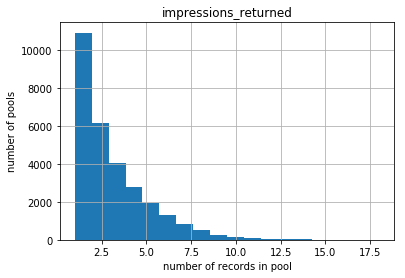

In [11]:
search_id.hist(bins=18)
plt.xlabel('number of records in pool')
plt.ylabel('number of pools')

#### Key by user, date range, and market (least restrictive within reason)

Without more user event data it's challenging to correctly coelesce searches. Searches in the same market with overlapping date ranges is one approach with the given data, however there's nuance to that approach as a cause of this can be user's considering staying at multiple locations either due to location, cost, number of guests, and availability as well as how those features interact with the listings considerations #TwoSidedMarketplace

As a rough initial cut given a user can only book in one place, aggregating by date range and user helps coelesce some of our searches while trying to mitigate bias. As we can see in the table below, for user `0077431ca40d7d0c028247ecb1da9874`, the first record and fourth record are more likely independent (although the user could have flexibility with the trip date), while the second or third requests are likely strongly anti-correlated with respect to booking. 

While the volume generated by this approach is appealing, the additional technical overhead of filtering responses and increased bias aren't justifiable at this point. This work does support the potential value add of future work in 

In [12]:
search_window = df.groupby(['id_user', 'query_checkin', 'query_checkout', 'query_market']).id_search.count()\
    .to_frame().rename(columns={'id_search': 'impressions_returned'})

search_window.head(10)

impressions_returned
id_user                          query_checkin query_checkout query_market                        
00226cf02c6c8907b096d0637bc84b29 12/7/18       12/9/18        Sao Paulo                         26
0077431ca40d7d0c028247ecb1da9874 1/9/19        1/13/19        Rio de Janeiro                     4
                                 2/27/19       3/6/19         Rio de Janeiro                    45
                                               3/7/19         Rio de Janeiro                    42
                                 3/13/19       3/14/19        Rio de Janeiro                     2
0088b42325fa2906faf06cb7bfcef953 12/19/18      12/25/18       Rio de Janeiro                     8
                                               12/26/18       Rio de Janeiro                     2
0092c34fa07040ccec7411af56e7ad2a 12/15/18      12/20/18       Rio de Janeiro                    16
009b1efd29ceb1277b8e503497a7560b 1/11/19       1/12/19        Sao Paulo                          1
                                               1/15/19        Sao Paulo                         44

Text(0,0.5,'number of pools')

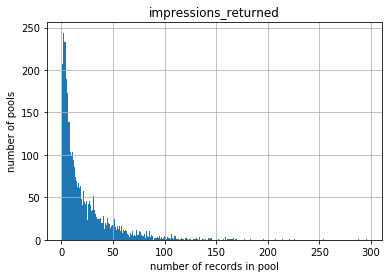

In [13]:
search_window.hist(bins=search_window.impressions_returned.max())
plt.xlabel('number of records in pool')
plt.ylabel('number of pools')

#### Key by user, full query parameters, and date of search.
We'll consider a unique query by it's attributes and the date of the search. (Again a call out to future pooling work). The search date criteria is included because our test and evaluation dataes are single days (noting one has 25% more records than the other) so we use this as an attempt to build intuition around the expected size of a pool in our validation set. 

In [14]:
search_window_full_query = df.groupby([i for i in df if (i in ['ds_search', 'id_user'] 
                                                         or i.startswith('query'))]).id_search.count()\
    .to_frame().rename(columns={'id_search': 'impressions_returned'})

search_window_full_query.head(15)

impressions_returned
id_user                          ds_search query_market   query_checkin query_checkout query_num_guests query_num_children query_num_infants query_radius query_price_max query_price_min query_center_lat query_center_lng                      
00226cf02c6c8907b096d0637bc84b29 11/21/18  Sao Paulo      12/7/18       12/9/18        2                0                  0                 2.861446      1.070000e+09    50             -23.59           -46.66                               1
                                                                                                                                             2.861502     -1.000000e+00   -1              -23.58           -46.64                               4
                                                                                                                                             2.861563      1.070000e+09    50             -23.58           -46.66                               1
                                                                                                                                             2.861606      1.070000e+09    50             -23.58           -46.65                               4
                                                                                                                                             2.861710      1.070000e+09    50             -23.58           -46.66                               1
                                                                                                                                             2.862022     -1.000000e+00   -1              -23.56           -46.65                               2
                                                                                                                                             2.862101     -1.000000e+00   -1              -23.56           -46.65                               6
                                                                                                                                             2.862210     -1.000000e+00   -1              -23.55           -46.66                               1
                                                                                                                                             5.722837     -1.000000e+00   -1              -23.59           -46.63                               1
                                                                                                                                             5.723167      1.070000e+09    50             -23.58           -46.65                               2
                                                                                                                                             5.723401     -1.000000e+00   -1              -23.58           -46.64                               1
                                                                                                                                             5.723618     -1.000000e+00   -1              -23.57           -46.64                               2
0077431ca40d7d0c028247ecb1da9874 11/20/18  Rio de Janeiro 2/27/19       3/7/19         2                0                  0                 1.318039     -1.000000e+00   -1              -22.97           -43.19                               7
                                                                                                                                                           5.760000e+02    0              -22.97           -43.19                               2
                                                                                                                                                           8.730000e+02    0              -22.97           -43.19                               2

Text(0,0.5,'number of pools')

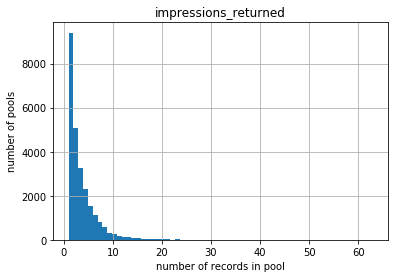

In [15]:
search_window_full_query.hist(bins=search_window_full_query.impressions_returned.max())
plt.xlabel('number of records in pool')
plt.ylabel('number of pools')

#### Impact of key parameterization
By moving from the most restrictive to a slightly less restrictive pooling we gain an averge of 15% in pool size, 
but the gain follows the skew of the volume. Future work in number of searches correlating with likelihood of booking is another interesting area to explore

In [20]:
description = pd.concat([i.describe(percentiles=pd.np.linspace(.2,.8,4)) for i in
                         [search_id, search_window, search_window_full_query]], axis=1)
description.columns = ['search_id', 'search_window', 'search_window_full_query']
description

,search_id,search_window,search_window_full_query
count,29236.000000,3615.000000,25523.000000
mean,2.788685,22.553250,3.194374
std,2.179137,27.655459,3.215936
min,1.000000,1.000000,1.000000
20%,1.000000,4.000000,1.000000
40%,2.000000,9.000000,2.000000
50%,2.000000,12.000000,2.000000
60.0%,3.000000,18.000000,3.000000
80%,4.000000,36.000000,5.000000
max,18.000000,296.000000,63.000000


####  Number of searches per user per day
There is a lot to explore in user search interactions. I'll curtail that discussion to allow for more time on the system itself with a look at user searches per day as some' support for pooling over grouping by search_id only. Here we see a stable search count per user per day

In [21]:
user_searches = df[['id_search', 'id_user', 'ds_search']].drop_duplicates().groupby(['id_user', 'ds_search'])\
.id_search.count().to_frame().rename(columns={'id_search': 'searches_per_user'}).reset_index().groupby('ds_search')\
.searches_per_user

user_searches.describe()

,count,mean,std,min,25%,50%,75%,max
ds_search,,,,,,,,
11/20/18,869.0,10.698504,11.633468,1.0,3.0,7.0,14.0,94.0
11/21/18,965.0,10.222798,10.957344,1.0,3.0,7.0,14.0,101.0
11/22/18,958.0,10.515658,11.095447,1.0,3.0,7.0,14.0,79.0


In [ ]:
#counts = df[['id_search', 'id_user', 'ds_search']].drop_duplicates().groupby(['id_user', 'ds_search'])\
#.id_search.count().to_frame().rename(columns={'id_search': 'searches_per_user'}).reset_index().groupby('ds_search')
#for _date, _count in counts:
#    plt.hist(_count.values[:500], bins=user_searches.describe()['max'].max().astype(int), histtype='bar')

ds_search
11/20/18    AxesSubplot(0.125,0.125;0.775x0.755)
11/21/18    AxesSubplot(0.125,0.125;0.775x0.755)
11/22/18    AxesSubplot(0.125,0.125;0.775x0.755)
Name: searches_per_user, dtype: object

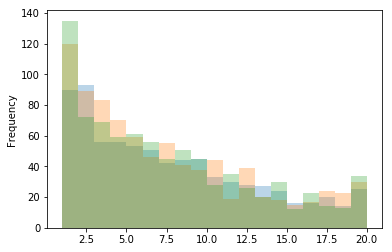

In [28]:
user_searches.plot.hist(bins=range(1, 21), histtype='bar', alpha=.3)

### Modeling

In [31]:
df.head()

,id_search,label,id_user,id_listing,ts_search,ds_search,ds_book,ds_contact,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_instant_bookable,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_room_type,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_has_pro_pictures,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
26,073080bb-8453-4c62-b679-8c48dd070dec,click,f9d0b13bfe4dc6a76862b4884f1c08e6,19cacd588e89c13d513ed7771484d43e,11/21/18 22:49,11/21/18,NaN,NaN,Sao Paulo,11/28/18,11/30/18,1,0,0,0.479950,220.0,0,-23.59,-46.68,0,143.71162,False,-23.59,-46.68,4.0,3.0,47.0,Entire Home,3.0,2.0,1,4,False,0,5.00,4.00,5.0,4.333334,5.000000,5.000000,1.0,NaN,0,0,39.919950,NaN,NaN,2.0,1125.0
122,9dbb29c4-50b3-4454-a399-00195f84f749,book,0e9f1bd36b2a4f1c66109f79041620de,ddf85752360235b031d183608c7512e9,11/21/18 2:17,11/21/18,11/23/18,11/23/18,Rio de Janeiro,2/28/19,3/26/19,1,0,0,0.915541,52.0,0,-22.97,-43.18,0,1109.05440,False,-22.98,-43.19,4.5,6.0,1.0,Entire Home,2.0,0.0,1,4,False,0,5.00,4.00,5.0,4.571429,4.857143,4.571429,4.0,0.084746,1,1,53.226597,0.8,0.87,1.0,1125.0
123,50c84f88-97ba-4697-8769-ee6cdce8347a,impression,0e9f1bd36b2a4f1c66109f79041620de,9d326721c8c97ac8c75bb7e86765750c,11/21/18 2:37,11/21/18,NaN,NaN,Rio de Janeiro,2/28/19,3/26/19,1,0,0,1.700818,52.0,0,-22.91,-43.17,0,944.90390,False,-22.91,-43.18,5.0,4.0,1.0,Entire Home,3.0,1.0,1,3,False,0,4.75,4.75,5.0,5.000000,5.000000,5.000000,0.0,0.000000,1,1,29.274628,0.64,0.90,2.0,1125.0
124,cc7cba4f-c214-48ca-b7ff-ea87782508d1,impression,0e9f1bd36b2a4f1c66109f79041620de,635ed69ff02cfb18d293bb74034c7e16,11/21/18 2:37,11/21/18,NaN,NaN,Rio de Janeiro,2/28/19,3/26/19,1,0,0,0.680327,-1.0,-1,-22.91,-43.17,1,2075.83450,False,-22.91,-43.17,0.0,0.0,2.0,Entire Home,5.0,1.0,2,9,False,0,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.000000,0.0,0.000000,0,0,NaN,NaN,NaN,2.0,1125.0
125,363dcd13-4ca0-4b8c-92ef-ebdc7fcaf05d,impression,0e9f1bd36b2a4f1c66109f79041620de,8d9f56d6feeb0fa7510db41c5c105c1e,11/21/18 2:37,11/21/18,NaN,NaN,Rio de Janeiro,2/28/19,3/26/19,1,0,0,0.680327,-1.0,-1,-22.91,-43.17,0,NaN,False,-22.91,-43.18,4.0,1.0,1.0,Entire Home,2.0,1.0,1,4,NaN,0,5.00,4.00,5.0,5.000000,5.000000,5.000000,2.0,0.005525,1,1,NaN,0.75,0.90,1.0,1125.0


In [32]:
numeric = df.select_dtypes(pd.np.number)
numeric.head()

,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_num_beds,listing_num_bedrooms,listing_person_capacity,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
26,1,0,0,0.479950,220.0,0,-23.59,-46.68,0,143.71162,-23.59,-46.68,4.0,3.0,47.0,3.0,2.0,4,0,5.00,4.00,5.0,4.333334,5.000000,5.000000,1.0,NaN,0,0,39.919950,NaN,2.0,1125.0
122,1,0,0,0.915541,52.0,0,-22.97,-43.18,0,1109.05440,-22.98,-43.19,4.5,6.0,1.0,2.0,0.0,4,0,5.00,4.00,5.0,4.571429,4.857143,4.571429,4.0,0.084746,1,1,53.226597,0.87,1.0,1125.0
123,1,0,0,1.700818,52.0,0,-22.91,-43.17,0,944.90390,-22.91,-43.18,5.0,4.0,1.0,3.0,1.0,3,0,4.75,4.75,5.0,5.000000,5.000000,5.000000,0.0,0.000000,1,1,29.274628,0.90,2.0,1125.0
124,1,0,0,0.680327,-1.0,-1,-22.91,-43.17,1,2075.83450,-22.91,-43.17,0.0,0.0,2.0,5.0,1.0,9,0,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.000000,0.0,0.000000,0,0,NaN,NaN,2.0,1125.0
125,1,0,0,0.680327,-1.0,-1,-22.91,-43.17,0,NaN,-22.91,-43.18,4.0,1.0,1.0,2.0,1.0,4,0,5.00,4.00,5.0,5.000000,5.000000,5.000000,2.0,0.005525,1,1,NaN,0.90,1.0,1125.0


Treatments for nulls is a critical component of model development, but to close the loop for a first baseline glm
I'll impute the mean. Subsequent work on mean vs specific value filling vs other treatments to come in subsequent 

In [35]:
numeric.isnull().mean().sort_values(ascending=False).head(10)

listing_cleaning_fee           0.258298
listing_weekly_price_factor    0.254520
listing_num_books_90day        0.138379
listing_review_rating          0.118778
listing_review_count           0.098062
listing_occupancy_rate         0.059917
listing_total_price            0.051282
listing_num_beds               0.049908
listing_num_bedrooms           0.049847
listing_property_type          0.049184
dtype: float64

#### Donatello
Donatello is a personal project of mine. It's still in development, but for currently supported use cases it can be a  helpful tool for building and evaluating the scoring components of ML systems. Here I'll use it to a build scorer for the likelihood of a given impression converting to a booking. Some of it's advantages include traceability and reproducibility, a transformation graph, and terse access to a variety of cross validation and metric evaluation strategies. Some of it's disadvantages include runtime speeds (parallelization is not fully supported yet) which can couple with unintentionally building lots of models (due to nesting grid search folds within cross val folds for metric estimates), and weak (but growing!) test coverage. Given more time or with existing infrastructue I'd certainly make strong considerations for using other tools or building more from scratch. 

NOTE: If it'd be helpful for interview-evaluation purposes to see any of the model development code built out, just let me know and I'd be happy to, thanks!

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

from donatello.components import core, data, estimator, transformers, measure
from donatello.utils import helpers

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def load_model(model=LogisticRegression()):

    graph = transformers.ModelDAG(set([]), {}, graphKwargs={'name': 'airbnb_recommendation'})
    
    n1 = transformers.Node('select', transformer=transformers.DatasetFlow(selectValue={'include': [pd.np.number]},
                                                                          selectMethod='data_type'))
    
    n2 = transformers.Node('impute', transformer=transformers.Imputer(), enforceTarget=True)
    n3 = transformers.Node('scale', transformer=transformers.StandardScaler(), enforceTarget=True)
    
    n4 = transformers.Node('ml', transformer=model)

    graph.add_edge_flow(n1, n2)
    graph.add_edge_flow(n2, n3)
    graph.add_edge_flow(n3, n4)

    return graph


def load_sculpture(df, 
                   model=load_model(), 
                   paramGrid={'model__ml__C': list(pd.np.logspace(-2, -0.01, 5))},
                   searchKwargs={'scoring': 'roc_auc', 'cv': 3}):
    df = df.copy()
    df['is_booked'] = df['label'] == 'book'
    
    # our first key decision - the index on which to fold. We can partition over stratification
    # of the target or we can keep all of a users searches in the same group. While
    # the former helps with simpler evaluation of metrics, I expect the latter to produce
    # a less biased result so I'll use that, with a callout that this effectively becomes 
    # a requirement when I look to build features with historical data or risk an inaccurate
    # representation of histor or leakage.
    dataset = data.Dataset(raw=df, target='is_booked', clay='group', groupDap={'attrPath': ['id_user']})

    est = estimator.Estimator(model=model,
                              paramGrid=paramGrid,
                              searchKwargs=searchKwargs,
                              method='predict_proba',
                              scorer='score_second'
                              )

    metrics = [measure.Metric(roc_auc_score), measure.Metric(average_precision_score),
               measure.FeatureWeights(sort='coefficients'), measure.ThresholdRates()]

    sculpture = core.Sculpture(dataset=dataset, estimator=est, metrics=metrics)

    return sculpture

    

In [161]:
s = load_sculpture(df, paramGrid=None, searchKwargs=None)

In [163]:
#s.fit()

In [164]:
helpers.view_sk_metric(s.measureCrossValidation['measurements']['roc_auc_score'])

,score
mean,0.658010
std,0.017343


In [165]:
helpers.view_sk_metric(s.measureCrossValidation['measurements']['average_precision_score'])

,score
mean,0.022187
std,0.002581


#### Baseline Evaluation
We have a `slightly` better than random scoring of impressions to bookings. Next we'll look at the relative impact of features via the coefficients of the Logistic Regression (note coefficients reflect the scaled data) before closing the loop on setting a baseline gain with which to compare against

In [152]:
s.measureCrossValidation['measurements']['feature_weights'].mean

,coefficients
names,
intercept_,-4.554460
listing_total_price,-0.430467
query_radius,-0.255333
listing_lat,-0.142383
listing_person_capacity,-0.129873
listing_cleanliness_rating,-0.103047
listing_num_recent_reservations,-0.079341
listing_weekly_discount,-0.064934
listing_communication_rating,-0.064086


In [157]:
def evaluate(model, df):
    scores = model.predict(df)
    df = df[[i for i in df if i in ['Estimator'] or ]
    df = pd.concat([df, scores])
    df
    df.groupby()

439       0.015783
440       0.007673
441       0.010170
442       0.007167
443       0.007021
444       0.008413
445       0.008679
446       0.008582
447       0.005600
448       0.007006
898       0.007099
899       0.012767
900       0.009845
901       0.009258
902       0.006443
903       0.006724
904       0.011588
905       0.005630
906       0.010593
907       0.007971
908       0.007858
909       0.006362
910       0.010045
911       0.019742
912       0.011351
913       0.007287
950       0.007490
951       0.008487
952       0.008817
953       0.004977
            ...   
177370    0.015392
177371    0.021645
177372    0.020370
177373    0.016732
177374    0.018144
177375    0.013694
177376    0.012504
177377    0.017121
177378    0.010793
177379    0.016181
177381    0.012168
177382    0.015985
177383    0.011182
177384    0.013641
177385    0.020865
177386    0.017809
177387    0.010473
177388    0.016142
177389    0.018400
177557    0.008128
177558    0.003492
177560    0.

In [87]:
n1 = transformers.Node('select', transformer=transformers.DatasetFlow(selectValue={'include': [pd.np.number]},
                                                                          selectMethod='data_type'))

In [118]:
    df = df.copy()
    df['is_booked'] = df['label'] == 'book'
    
    # our first key decision - the index on which to fold. We can partition over stratification
    # of the target or we can keep all of a users searches in the same group. While
    # the former helps with simpler evaluation of metrics, I expect the latter to produce
    # a less biased result so I'll use that.
    dataset = data.Dataset(raw=df, target='is_booked', clay='group', groupDap={'attrPath': ['id_user']})

In [157]:
x = df.iloc[0] 

In [162]:
distances.describe()

count    81530.000000
mean         7.055259
std         56.381380
min          0.000000
25%          1.023632
50%          1.511299
75%          4.245019
max       6588.378647
dtype: float64

In [161]:
df['distance'] = df.apply(lambda x: haversine((x['query_center_lat'], x['query_center_lng']),
                                         (x['listing_lat'], x['listing_lng'])
                                         ), axis=1
                     ).round(0) #distance in km

In [188]:
df['query_radius'] = df.query_radius.round(0)

In [189]:
distance_per_radii = df[['query_radius','distance']].groupby('query_radius').max()

In [290]:
distance_per_radii.T

query_radius,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,39.0,40.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,72.0,73.0,74.0,75.0,77.0,83.0,84.0,86.0,87.0,88.0,92.0,93.0,94.0,95.0,96.0,99.0,100.0,101.0,102.0,103.0,105.0,106.0,108.0,109.0,110.0,111.0,112.0,113.0,115.0,116.0,118.0,119.0,122.0,128.0,132.0,133.0,134.0,137.0,142.0,145.0,146.0,147.0,148.0,149.0,150.0,151.0,155.0,169.0,174.0,176.0,186.0,187.0,188.0,189.0,191.0,192.0,198.0,199.0,200.0,204.0,205.0,206.0,212.0,213.0,214.0,215.0,216.0,217.0,218.0,219.0,220.0,221.0,223.0,224.0,225.0,226.0,227.0,234.0,235.0,240.0,245.0,252.0,253.0,257.0,266.0,274.0,290.0,321.0,343.0,346.0,347.0,352.0,354.0,379.0,380.0,399.0,400.0,419.0,421.0,426.0,431.0,433.0,435.0,450.0,490.0,501.0,504.0,505.0,587.0,692.0,762.0,794.0,858.0,860.0,912.0,1004.0,1685.0,1716.0,3822.0,4640.0,4704.0
distance,1.511812,3.022854,6.749833,5.582868,7.827633,14.371274,10.559848,10.811424,12.933534,14.497393,15.714333,17.435302,18.855952,20.96353,22.001995,18.72424,23.487172,21.992661,28.773196,26.097887,30.130769,30.552228,31.729608,35.672635,36.615516,40.605769,35.683849,39.416205,42.247234,36.708503,37.701722,42.253271,48.79485,51.792623,47.126284,39.996092,42.165106,57.050246,55.713017,56.501713,24.563138,61.472548,58.964669,67.118751,56.868187,67.325233,65.21652,72.710991,80.262651,79.680181,65.035467,72.858922,81.960904,68.348674,87.023634,48.749805,62.574069,42.401478,91.505689,66.811745,85.60726,102.05269,88.019275,48.780189,91.093014,93.48529,24.971913,78.905513,47.437925,113.274431,68.332033,113.098013,106.099298,77.759134,115.403059,104.174184,132.588683,119.094431,84.676848,111.500755,137.908161,80.660168,146.229269,114.506458,141.992984,103.250716,144.65296,123.146523,125.166443,141.776101,122.349095,108.984801,122.362095,120.138689,76.219213,162.660541,26.934789,158.676761,67.828999,146.074578,14.030855,128.381294,182.293266,60.005149,59.390992,135.455466,170.463285,210.013902,220.666303,203.940308,171.140608,53.48353,116.481076,226.600066,192.295211,131.202204,118.72317,89.051962,290.436044,203.713222,143.232139,139.025815,145.546502,108.825283,156.481586,223.943563,310.044652,243.84836,265.906008,273.105443,171.009513,295.760982,234.143048,306.275878,188.809573,271.279886,31.254944,328.875522,246.079975,281.512716,260.554555,264.443963,326.565134,226.71365,314.382561,153.94211,214.699468,241.442064,123.683587,202.594918,258.326482,237.479171,303.045128,160.663248,259.685095,667.869574,330.640559,143.062686,393.496688,302.546008,478.648262,404.159106,374.55182,580.798335,463.174853,381.555066,616.471055,224.272256,455.755337,553.223064,614.700646,482.966489,506.970875,476.104501,602.618332,797.992247,484.257334,891.965018,843.789643,1125.533619,982.790945,1425.828137,1133.470917,2187.456932,1792.008151,5978.644639,3451.68835,6588.378647


In [ ]:
radius_of_distance = 

In [81]:
pd.options.display.max_columns = 999

In [94]:
____ = df.copy()

In [97]:
df_all = df.copy()

11/20/18    25608
11/21/18    27548
11/22/18    28374
11/23/18    27344
11/25/18    29007
11/26/18    39707
Name: ds_search, dtype: int64

In [99]:
df.shape

(81530, 49)

(1907, 23407)

In [101]:
combinations = len(df.id_user.value_counts()) * len(df.id_listing.value_counts())

In [102]:
df.shape[0] * 1.0 / combinations 

0.0018265055413821344

In [104]:
df.head()

,id_search,label,id_user,id_listing,ts_search,ds_search,ds_book,ds_contact,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_instant_bookable,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_room_type,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_has_pro_pictures,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
26,073080bb-8453-4c62-b679-8c48dd070dec,click,f9d0b13bfe4dc6a76862b4884f1c08e6,19cacd588e89c13d513ed7771484d43e,11/21/18 22:49,11/21/18,NaN,NaN,Sao Paulo,11/28/18,11/30/18,1,0,0,0.479950,220.0,0,-23.59,-46.68,0,143.71162,False,-23.59,-46.68,4.0,3.0,47.0,Entire Home,3.0,2.0,1,4,False,0,5.00,4.00,5.0,4.333334,5.000000,5.000000,1.0,NaN,0,0,39.919950,NaN,NaN,2.0,1125.0
122,9dbb29c4-50b3-4454-a399-00195f84f749,book,0e9f1bd36b2a4f1c66109f79041620de,ddf85752360235b031d183608c7512e9,11/21/18 2:17,11/21/18,11/23/18,11/23/18,Rio de Janeiro,2/28/19,3/26/19,1,0,0,0.915541,52.0,0,-22.97,-43.18,0,1109.05440,False,-22.98,-43.19,4.5,6.0,1.0,Entire Home,2.0,0.0,1,4,False,0,5.00,4.00,5.0,4.571429,4.857143,4.571429,4.0,0.084746,1,1,53.226597,0.8,0.87,1.0,1125.0
123,50c84f88-97ba-4697-8769-ee6cdce8347a,impression,0e9f1bd36b2a4f1c66109f79041620de,9d326721c8c97ac8c75bb7e86765750c,11/21/18 2:37,11/21/18,NaN,NaN,Rio de Janeiro,2/28/19,3/26/19,1,0,0,1.700818,52.0,0,-22.91,-43.17,0,944.90390,False,-22.91,-43.18,5.0,4.0,1.0,Entire Home,3.0,1.0,1,3,False,0,4.75,4.75,5.0,5.000000,5.000000,5.000000,0.0,0.000000,1,1,29.274628,0.64,0.90,2.0,1125.0
124,cc7cba4f-c214-48ca-b7ff-ea87782508d1,impression,0e9f1bd36b2a4f1c66109f79041620de,635ed69ff02cfb18d293bb74034c7e16,11/21/18 2:37,11/21/18,NaN,NaN,Rio de Janeiro,2/28/19,3/26/19,1,0,0,0.680327,-1.0,-1,-22.91,-43.17,1,2075.83450,False,-22.91,-43.17,0.0,0.0,2.0,Entire Home,5.0,1.0,2,9,False,0,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.000000,0.0,0.000000,0,0,NaN,NaN,NaN,2.0,1125.0
125,363dcd13-4ca0-4b8c-92ef-ebdc7fcaf05d,impression,0e9f1bd36b2a4f1c66109f79041620de,8d9f56d6feeb0fa7510db41c5c105c1e,11/21/18 2:37,11/21/18,NaN,NaN,Rio de Janeiro,2/28/19,3/26/19,1,0,0,0.680327,-1.0,-1,-22.91,-43.17,0,NaN,False,-22.91,-43.18,4.0,1.0,1.0,Entire Home,2.0,1.0,1,4,NaN,0,5.00,4.00,5.0,5.000000,5.000000,5.000000,2.0,0.005525,1,1,NaN,0.75,0.90,1.0,1125.0


## Understanding the user's search experience.

The metadata a user supplies during search frames the context of the available listings to return. This requires heavy crossfunctional coordination as varying the degree of rigidity and requirements on the backend impacts a wide array of downstream internal consumers from design to site reliability with the users themselves to still consider. Optimizing the search experience requires consideration for all of these groups. 

In the context of this dataset we have a collection of listing results returned (assumption:= all search returns are  considered impressions due to the lack of null or other values in the label set - depending on the user device agent the user may not witness the listing but for this takehome I'll ignore those and similar cases) from a user request 

In [131]:
search_window = df.groupby(['id_user', 'query_checkin', 'query_checkout', 'query_market']).id_search.count()\
    .to_frame().rename(columns={'id_search': 'impressions_returned'})

search_window.head(10)

impressions_returned
id_user                          query_checkin query_checkout query_market                        
00226cf02c6c8907b096d0637bc84b29 12/7/18       12/9/18        Sao Paulo                         26
0077431ca40d7d0c028247ecb1da9874 1/9/19        1/13/19        Rio de Janeiro                     4
                                 2/27/19       3/6/19         Rio de Janeiro                    45
                                               3/7/19         Rio de Janeiro                    42
                                 3/13/19       3/14/19        Rio de Janeiro                     2
0088b42325fa2906faf06cb7bfcef953 12/19/18      12/25/18       Rio de Janeiro                     8
                                               12/26/18       Rio de Janeiro                     2
0092c34fa07040ccec7411af56e7ad2a 12/15/18      12/20/18       Rio de Janeiro                    16
009b1efd29ceb1277b8e503497a7560b 1/11/19       1/12/19        Sao Paulo                          1
                                               1/15/19        Sao Paulo                         44

In [130]:
search_window.sort_values('impressions_returned', ascending=False).head(10)

,,,impressions_returned
id_user,query_checkin,query_checkout,
c8f4ca9f2a9667cc974d8ac7f5745d8c,12/3/18,12/7/18,296
37b4be1f990349af1c0e85427d0e8336,12/29/18,1/6/19,288
110cfe2944aedf6304298f20cca81021,2/16/19,2/23/19,254
9fefb19b0cff8ed64c22bbe4c02acef5,11/26/18,12/7/18,226
edb9cc5272069ae0a4bb1500f1c0c9e2,3/2/19,3/5/19,221
ede9ff13c445dc2d74c755213d1f9fdd,3/1/19,3/6/19,215
6ec8fc0c4781770300767cc55d05b901,2/27/19,3/8/19,208
51adc96ab07464e2f4f59b6b9d60b811,12/30/18,1/2/19,196
58795b0870ce8add1d4dde021a44c668,3/1/19,3/4/19,183


In [125]:
search_id = df.groupby(['id_search']).id_user.count().sort_values(ascending=False)\
.to_frame().rename(columns={'id_user': 'impressions_returned'})
search_id.head(10)

,impressions_returned
id_search,
2da8c6e2-5704-45e7-8702-c67f08889b9c,18
b6e5515d-1947-44f0-b284-f70a8b14f3cb,17
42974b36-c700-4798-af5f-4416ec5683b7,17
76d4e52b-c498-4b42-95fa-7e3e3d4b27ba,17
0dc7078b-b344-42c5-9cb5-c715a1cc21dd,17
645d37cf-7995-4348-b3c2-65daee9ce44a,17
abb0d1bf-8b8f-446c-bfd4-25b2ebcb73da,17
ca0f261c-5bc3-4920-a2d2-ed03542efdb9,16
8753c04d-d964-44d1-9619-323c677e8d61,16


In [116]:
display(search_id.impressions_returned.value_counts().to_frame().T)
display(search_window.id_search.value_counts().to_frame().T)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
impressions_returned,10917,6179,4025,2795,1926,1325,856,529,264,170,87,66,44,21,15,10,6,1


,2,3,1,4,5,7,6,8,10,9,11,12,13,14,16,18,15,17,21,31,24,19,22,27,23,28,20,26,32,29,30,33,40,34,38,44,51,35,36,25,37,39,45,46,42,43,50,49,52,54,56,58,48,47,55,41,53,62,60,73,67,57,63,75,61,82,69,76,85,59,107,77,80,74,68,71,64,87,79,65,70,100,72,110,78,95,88,83,66,86,84,134,103,159,93,97,81,91,90,92,94,99,104,167,105,108,121,131,116,143,120,128,145,221,96,98,288,296,101,109,111,113,115,117,125,129,137,157,161,163,165,169,183,215,226,208,138,102,106,112,118,122,130,132,140,196,144,152,162,164,166,170,178,254
id_search,240,230,206,187,171,138,136,104,102,100,92,83,75,69,67,62,62,59,58,53,48,47,44,44,41,41,41,40,36,36,34,30,28,27,27,26,25,25,24,23,22,20,20,19,19,18,17,17,16,16,16,16,16,14,13,13,12,12,11,11,10,10,10,10,10,10,10,9,9,8,8,7,7,6,6,6,6,6,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Evaluation
As a baseline metric we'll look at the ave

## Simple - predict the most popular (NB. there's LOTS of issues with this) 
We'll define most popular as the 

In [ ]:
df['is_booked'] = df.label == 'book'


In [73]:
df['temp'] = 1

In [74]:
temp = df[['id_user', 'id_listing', 'temp']].head(1000).pivot_table(index='id_user', columns='id_listing', values='temp'
                                                    )

## Rules for valid listings:
    1) query_num_guests < listing_person_capacity (implicit assumption of invariant 
       wrt queriers guests/ kids / infants and capacity)
    2) query_price_max  == (-1 or < listing_total_price)
    3) query_min_price > listing_min_price
    4) listing_minimum_night < query_checkout - query_checkin

In [ ]:
df['search_date'] = df.ts_search.dt.date.

In [88]:
df[['query_price_min', 'query_price_max']].describe()

,query_price_min,query_price_max
count,177588.000000,1.775880e+05
mean,4.711563,1.284573e+07
std,37.856419,1.165330e+08
min,-1.000000,-1.000000e+00
25%,-1.000000,-1.000000e+00
50%,-1.000000,-1.000000e+00
75%,0.000000,5.100000e+01
max,2758.000000,1.070000e+09


In [84]:
df.query_market.value_counts()

Rio de Janeiro    133440
Sao Paulo          44148
Name: query_market, dtype: int64

In [86]:
df.query_radius.describe(percentiles=pd.np.linspace(.05, .95, 19))

count                 177588.000000
mean                      15.634096
std                       97.100965
min                        0.021910
5%                         0.247259
10%                        0.405207
15%                        0.587986
20%                        0.755590
25%                        0.860849
30%                        1.059849
35%                        1.318039
40%                        1.362181
44.99999999999999%         1.592191
49.99999999999999%         1.935646
50%                        1.935646
54.99999999999999%         2.892904
60%                        3.622588
65%                        4.243006
70%                        6.235035
75%                       12.771826
80%                       24.999628
85%                       24.999628
90%                       24.999628
95%                       25.216822
max                     5522.825700
Name: query_radius, dtype: float64

In [40]:
from donatello.components.transformers import OneHotEncoder

In [42]:
_targets = OneHotEncoder().fit_transform(df[['label']])

In [10]:
df.shape

(177588, 49)

In [34]:
df.label.value_counts()

impression      130031
click            42251
host_contact      3066
book              2240
Name: label, dtype: int64

In [28]:
df.label = df.label.fillna('None')

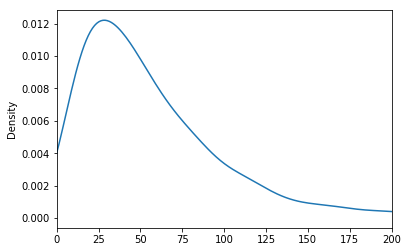

In [39]:
df.id_user.value_counts().plot(kind='kde')
plt.xlim(0, 200)
plt.show()

In [13]:
from donatello.components import data

In [ ]:
d = data.Dataset()

Issues with collaborative filtering or historical item matching - these methods have been developed under the assumptions of continuous availibility and supply (typically grocery stores do not often run out of bananas and netflix effectivley has infinite copies of movies serve and niether has a price as volatile as AirBnB listings can be)